In [1]:
! pip install pyproj shapely geopy plotly geopandas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score
import plotly.express as px
import plotly.graph_objects as go
import json
import requests
from geopy.distance import geodesic
import pyproj
import shapely
import geopandas as gpd
from IPython.display import display
import plotly

import plotly.io as pio

pio.templates[pio.templates.default].layout['font']["family"] = "Latin Modern Roman"
pio.templates[pio.templates.default].layout['font']["color"] = "black"

In [3]:
def plot_confusion_matrix(target, preds, target_names, *, title=None, ax=None, figsize=(10,10), dpi=100, colorbar=False, fontsize=10, cmap='viridis', normalize=None):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ConfusionMatrixDisplay.from_predictions(target, preds, cmap=cmap, ax=ax, colorbar=colorbar, labels=target_names,
                                            text_kw={'fontsize': fontsize}, normalize=normalize, values_format='.2f')
    # remove the text from che cells where there is 0
    for i in range(len(target_names)):
        for j in range(len(target_names)):
            if ax.texts[i*len(target_names)+j].get_text() == '0.00':
                ax.texts[i*len(target_names)+j].set_text('-')
    
    plt.sca(ax)
    ax.set_xticklabels(target_names, rotation=45, ha='right')    
    
    title = title if title is not None else 'Confusion Matrix'
    plt.title(title)

In [4]:
limits_it_provinces_geojson = "https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_provinces.geojson"

response = requests.get(limits_it_provinces_geojson)

provinces = json.loads(response.text)

gdf_provinces = gpd.GeoDataFrame.from_features(provinces['features'])

# invert lat and lon
gdf_provinces['geometry'] = gdf_provinces['geometry'].apply(lambda x: shapely.ops.transform(lambda x, y: (y, x), x))

gdf_provinces

,geometry,prov_name,prov_istat_code_num,prov_acr,reg_name,reg_istat_code,reg_istat_code_num,prov_istat_code
0,"POLYGON ((45.58222 7.89397, 45.57985 7.89654, ...",Torino,1,TO,Piemonte,01,1,001
1,"POLYGON ((45.74244 7.92900, 45.74196 7.92584, ...",Vercelli,2,VC,Piemonte,01,1,002
2,"POLYGON ((45.82981 8.42079, 45.83010 8.42028, ...",Novara,3,NO,Piemonte,01,1,003
3,"MULTIPOLYGON (((44.42794 6.94540, 44.42759 6.9...",Cuneo,4,CN,Piemonte,01,1,004
4,"POLYGON ((45.11667 7.96685, 45.11673 7.96729, ...",Asti,5,AT,Piemonte,01,1,005
...,...,...,...,...,...,...,...,...
102,"MULTIPOLYGON (((40.65584 9.46502, 40.65417 9.4...",Sassari,90,SS,Sardegna,20,20,090
103,"MULTIPOLYGON (((39.91741 9.28037, 39.91454 9.2...",Nuoro,91,NU,Sardegna,20,20,091
104,"MULTIPOLYGON (((39.09924 8.84872, 39.10047 8.8...",Cagliari,92,CA,Sardegna,20,20,092
105,"MULTIPOLYGON (((40.18982 8.78200, 40.19254 8.7...",Oristano,95,OR,Sardegna,20,20,095


In [5]:
def get_province(lat, lon):
    point = shapely.geometry.Point(lat, lon)
    for _, row in gdf_provinces.iterrows():
        if point.within(row['geometry']):
            return row['prov_name']
    # if the point is not in any province, return the closest one
    distances = gdf_provinces['geometry'].apply(lambda x: point.distance(x))
    return gdf_provinces.loc[distances.idxmin()]['prov_name']

torino = (45.0703, 7.6869)
milano = (45.4642, 9.1900)

print(get_province(*torino))
print(get_province(*milano))

Torino
Milano


================================================== LLaMA ==================================================
F1 score: 0.4934524611473143
Accuracy: 0.6809290953545232


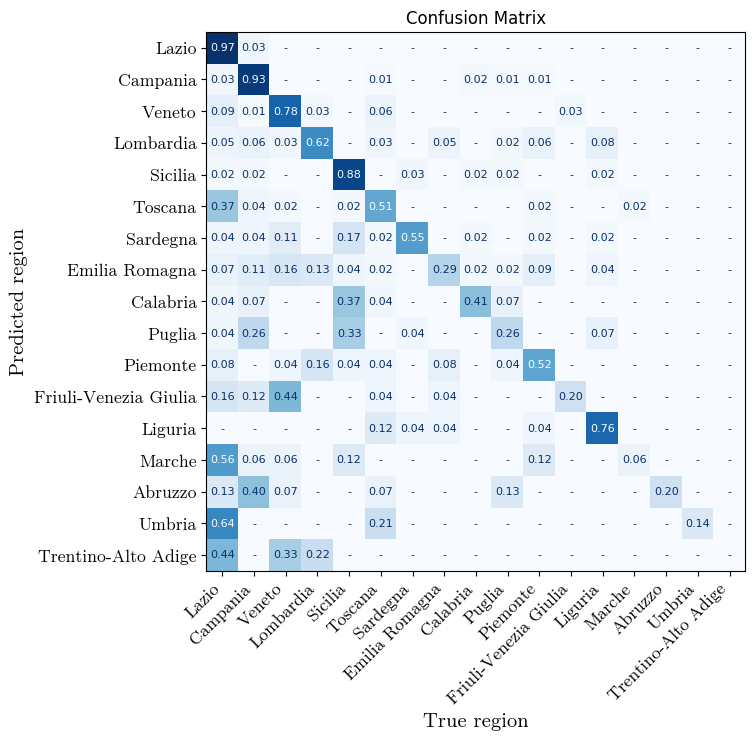




================================================== ANITA ==================================================
F1 score: 0.541206407731309
Accuracy: 0.7237163814180929


<Figure size 640x480 with 0 Axes>

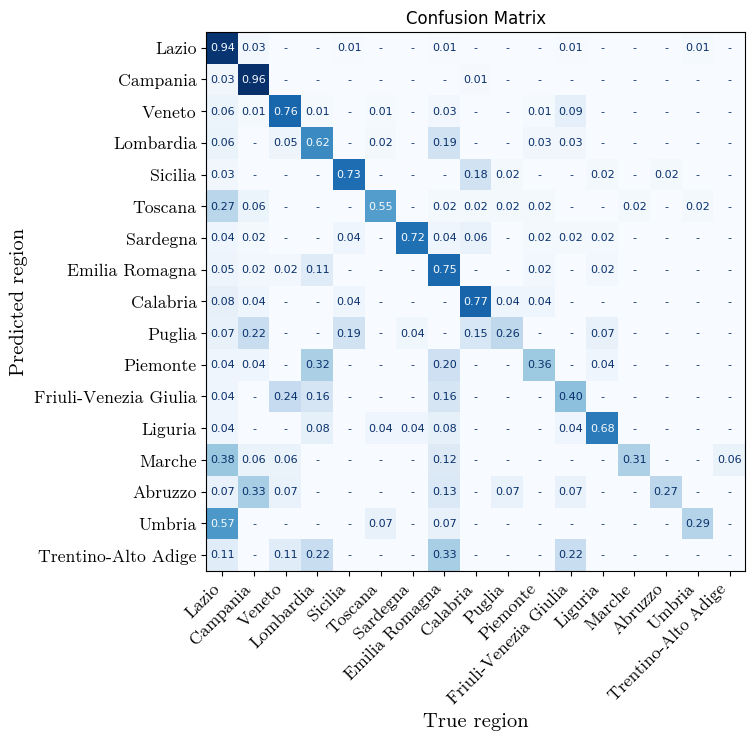




================================================== MINERVA ==================================================
F1 score: 0.4729939720364821
Accuracy: 0.6601466992665037


<Figure size 640x480 with 0 Axes>

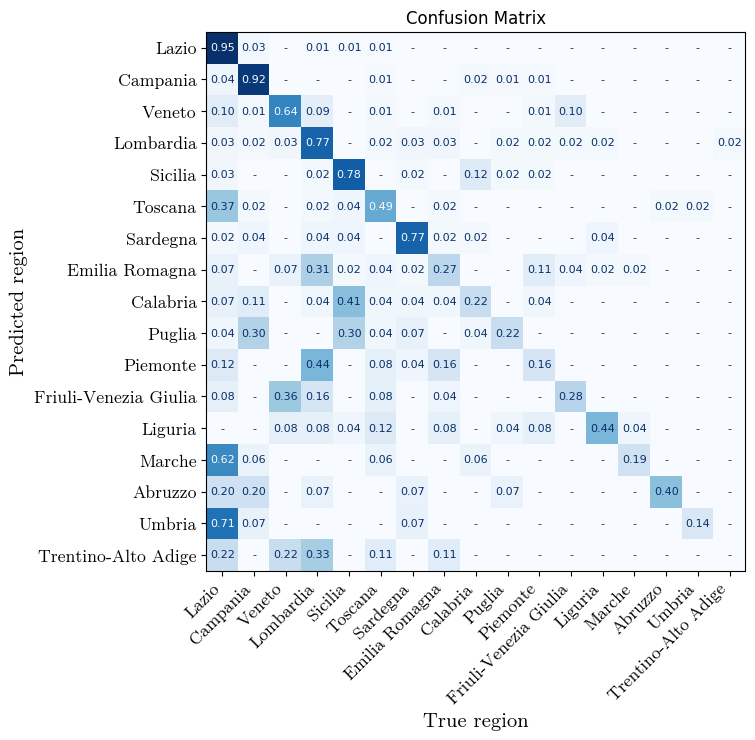

<Figure size 640x480 with 0 Axes>

In [6]:
for MODEL in ['LLaMA', 'ANITA', 'MINERVA']:
    print('='*50 + f' {MODEL} ' + '='*50)
    
    ############################################
    # CLASSIFICATION ERROR ANALYSIS
    ############################################
    
    df = pd.read_csv(f'out/GeoLingIt/predictions_{MODEL}.tsv', sep='\t').set_index('id')

    print('F1 score:', f1_score(df['true_region'], df['pred_region'], average='macro'))
    print('Accuracy:', accuracy_score(df['true_region'], df['pred_region']))

    class_prob = df['true_region'].value_counts() / df['true_region'].value_counts().sum()
    target_names = class_prob.keys()

    # plt.rcParams["font.family"] = "Latin Modern Roman"
    # plt.rcParams["font.size"] = 12
    plot_confusion_matrix(df['true_region'], df['pred_region'], target_names=target_names, fontsize=8, normalize='true', figsize=(7,7), cmap='Blues')
    # change font of x labels and y labels
    plt.xticks(fontsize=12, fontname='Latin Modern Roman')
    plt.yticks(fontsize=12, fontname='Latin Modern Roman')
    plt.xlabel('True region', fontsize=14, fontname='Latin Modern Roman')
    plt.ylabel('Predicted region', fontsize=14, fontname='Latin Modern Roman')
    plt.show()
    plt.savefig(f'out/GeoLingIt/confusion_matrix_{MODEL}.eps', format='eps')
    
    ############################################
    # REGRESSION ERROR ANALYSIS
    ############################################
    
    # compute the error in km and the province for each prediction (using the geographical coordinates and the geojon file)
    df['error'] = df.apply(lambda x: geodesic((x['true_latitude'], x['true_longitude']), (x['pred_latitude'], x['pred_longitude'])).km, axis=1)
    df['province'] = df.apply(lambda x: get_province(x['true_latitude'], x['true_longitude']), axis=1)

    # df for the choropleth map
    province_color_df = pd.DataFrame({
        'province': [r['properties']['prov_name'] for r in provinces['features']],
        'region': [r['properties']['reg_name'] for r in provinces['features']],
    })
    province_color_df['error_sum'] = province_color_df['province'].apply(lambda x: df[df['province'] == x]['error'].sum() if x in df['province'].values else None)
    province_color_df['missing'] = province_color_df['province'].apply(lambda x: 0 if x not in df['province'].values else None)
    province_color_df['error_mean'] = province_color_df['province'].apply(lambda x: df[df['province'] == x]['error'].mean() if x in df['province'].values else None)

    # plot the sum of error and the mean of error for each province
    for method in ['sum', 'mean']:
        fig = px.choropleth_mapbox(province_color_df,
                                geojson=provinces,
                                locations="province",
                                featureidkey="properties.prov_name",
                                color=f'error_{method}',
                                color_continuous_scale='cividis',
                                mapbox_style="white-bg",
                                range_color=[0, 5500 if method == 'sum' else 650],
                                zoom=5.3,
                                center = {"lat": 42, "lon": 12.5},
                                opacity=1,
                                height=810,
                                width=900)
        fig.update_traces(marker_line_width=1, marker_line_color='black')

        # color white the missing provinces
        fig.add_trace(go.Choroplethmapbox(geojson=provinces,
                                        locations=province_color_df[province_color_df['missing'] == 0]['province'],
                                        featureidkey="properties.prov_name",
                                        z=[1]*province_color_df[province_color_df['missing'] == 0].shape[0],
                                        colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],
                                        showscale=False,
                                        marker_line_width=1,
                                        marker_line_color='black',
                                        hoverinfo='skip',
                                        below=False
                                        ))

        fig.update_layout(coloraxis_colorbar=dict(title=f'km error ({method})', tickfont=dict(size=18)),
                        showlegend=False, margin={"r":0,"t":0,"l":0,"b":0})
        fig.update_geos(fitbounds="locations", visible=False)
        # fig.show(config={'scrollZoom': False})
        fig.write_image(f'out/GeoLingIt/map_{MODEL}_{method}.eps', scale=3)
    
    print('\n\n')